In [96]:
import pandas as pd
import numpy as np

In [97]:
monthly_log_returns = pd.read_csv("../data/monthly_log_returns.csv", index_col=0, parse_dates=True)
cov_matrix = monthly_log_returns.cov()

In [98]:
S = cov_matrix.values
eigenvalues = np.linalg.eigvalsh(S) 
condition_number = np.max(eigenvalues)/np.min(eigenvalues)
print("The condition number is:", condition_number)

The condition number is: 29.343806918848998


In [99]:
from sklearn.covariance import LedoitWolf

In [100]:
lw = LedoitWolf() 
lw.fit(monthly_log_returns.values)
S_lw = lw.covariance_ 
delta = lw.shrinkage_ 
print("Fitted shrinkage is:", delta)

Fitted shrinkage is: 0.16415926864403999


In [101]:
S_lw_df = pd.DataFrame(S_lw, index=monthly_log_returns.columns, columns=monthly_log_returns.columns)
eigenvalues_lw = np.linalg.eigvals(S_lw)
cond_lw = eigenvalues_lw.max()/eigenvalues_lw.min()
print("Condition Number with Ledoit Wolf Shrinkage is:", cond_lw)


Condition Number with Ledoit Wolf Shrinkage is: 13.285248792972853


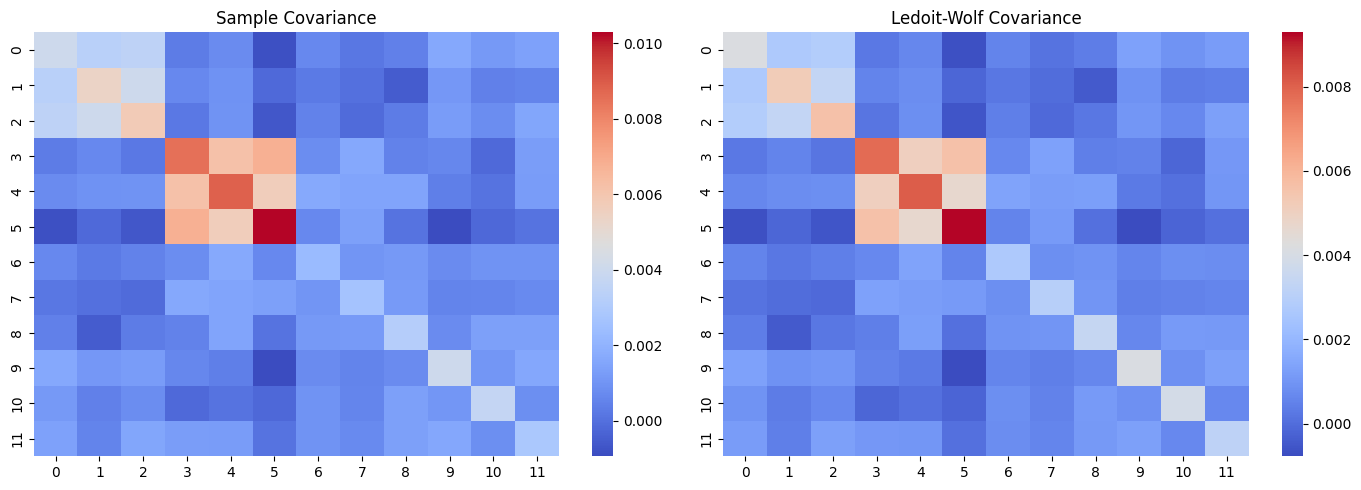

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(S, ax=axes[0], cmap="coolwarm")
axes[0].set_title("Sample Covariance")

sns.heatmap(S_lw, ax=axes[1], cmap="coolwarm")
axes[1].set_title("Ledoit-Wolf Covariance")

plt.tight_layout()
plt.show()

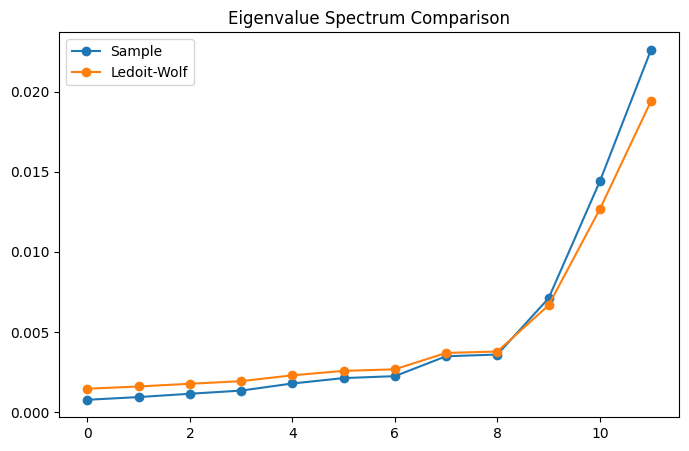

In [103]:
eig_sample = np.linalg.eigvalsh(S)
eig_lw = np.linalg.eigvalsh(S_lw)

plt.figure(figsize=(8,5))
plt.plot(sorted(eig_sample), marker='o', label="Sample")
plt.plot(sorted(eig_lw), marker='o', label="Ledoit-Wolf")
plt.title("Eigenvalue Spectrum Comparison")
plt.legend()
plt.show()

In [104]:
rf_annual = 0.067
rf = rf_annual/12

In [105]:
mu = monthly_log_returns.mean().values
ones = np.ones(len(mu))
excess_mu = mu - rf

numerator_sample = np.linalg.solve(S, excess_mu)
denominator_sample = ones @ numerator_sample

w_sample = numerator_sample / denominator_sample

numerator_lw = np.linalg.solve(S_lw, excess_mu)
denominator_lw = ones @ numerator_lw

w_lw = numerator_lw / denominator_lw

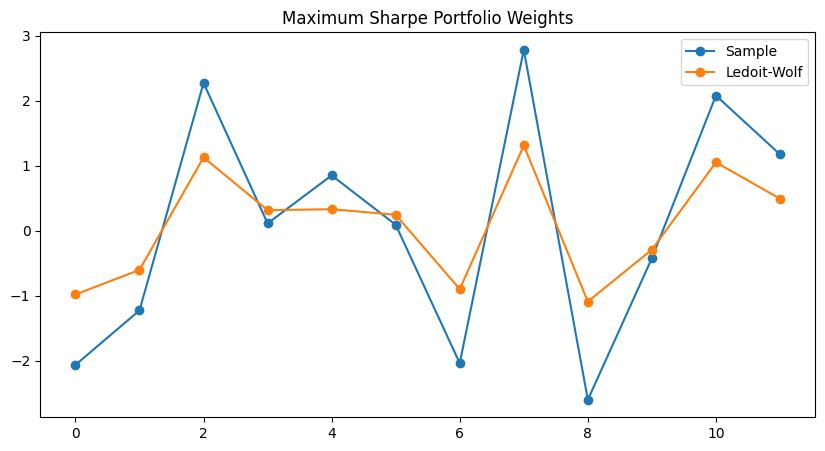

In [106]:
plt.figure(figsize=(10,5))
plt.plot(w_sample, marker='o', label="Sample")
plt.plot(w_lw, marker='o', label="Ledoit-Wolf")
plt.title("Maximum Sharpe Portfolio Weights")
plt.legend()
plt.show()

Lets build the bootstrap resampling experiment:

In [107]:
R = monthly_log_returns.values
T, N = R.shape

n_boot = 1000

weights_sample = np.zeros((n_boot, N))
weights_lw = np.zeros((n_boot, N))

ones = np.ones(N)

Average weight std (Sample): 23.52965855922226
Average weight std (LW): 6.31991085812363


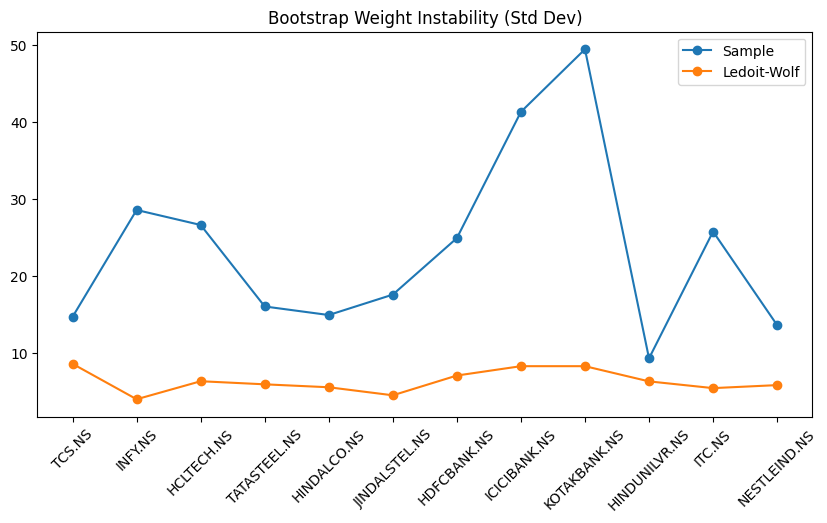

In [108]:
for b in range(n_boot):
    indices = np.random.choice(T,T,replace=True)
    R_boot = R[indices]

    S_boot = np.cov(R_boot, rowvar=False)
    mu_boot = R_boot.mean(axis=0)
    excess_mu_boot = mu_boot - rf

    try:
        num_sample = np.linalg.solve(S_boot, excess_mu_boot)
        w_sample = num_sample/(ones @ num_sample)
        weights_sample[b] = w_sample

    except np.linalg.LinAlgError:
        weights_sample[b] = np.nan

    lw = LedoitWolf().fit(R_boot)
    S_lw_boot = lw.covariance_

    num_lw = np.linalg.solve(S_lw_boot, excess_mu_boot)
    w_lw = num_lw/(ones@num_lw)
    weights_lw[b] = w_lw

valid_mask = ~np.isnan(weights_sample).any(axis=1)
weights_sample = weights_sample[valid_mask]
weights_lw = weights_lw[valid_mask]
std_sample = np.std(weights_sample, axis=0)
std_lw = np.std(weights_lw, axis=0)

print("Average weight std (Sample):", np.mean(std_sample))
print("Average weight std (LW):", np.mean(std_lw))
plt.figure(figsize=(10,5))
plt.plot(std_sample, marker='o', label="Sample")
plt.plot(std_lw, marker='o', label="Ledoit-Wolf")

plt.xticks(range(N), monthly_log_returns.columns, rotation=45)
plt.title("Bootstrap Weight Instability (Std Dev)")
plt.legend()
plt.show()